# read dicom

## reference
https://www.kaggle.com/randy19962/dicom

In [5]:
# !pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

In [1]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Read Dicom

In [82]:
def read_dicom(path):
    g = glob.glob(path + '/CT*.dcm')
    slices = [pydicom.read_file(s) for s in g]
    slices.sort(key=lambda x: int(x.InstanceNumber))
    print('RescaleIntercept :{}'.format(slices[0].RescaleIntercept))
    print('RescaleSlope :{}'.format(slices[0].RescaleSlope))
    print('SliceThickness :{}'.format(slices[0].SliceThickness))
    print('Pixel Spacing  :{}'.format(slices[0].PixelSpacing ))

    return slices

In [83]:
def show_raw_pixel(slices):
    #讀出像素值並且儲存成numpy的格式
    image = slices.pixel_array
    plt.figure(figsize = (12,12))
    plt.imshow(image, cmap=plt.cm.gray)
    plt.show()

In [84]:
slices = read_dicom('data/20201110_CBCT加reg檔案/L224_GYN/20190308_CBCT')

RescaleIntercept :-1000
RescaleSlope :1
SliceThickness :1.98849010467529
Pixel Spacing  :[9.0802038e-1, 9.0802038e-1]


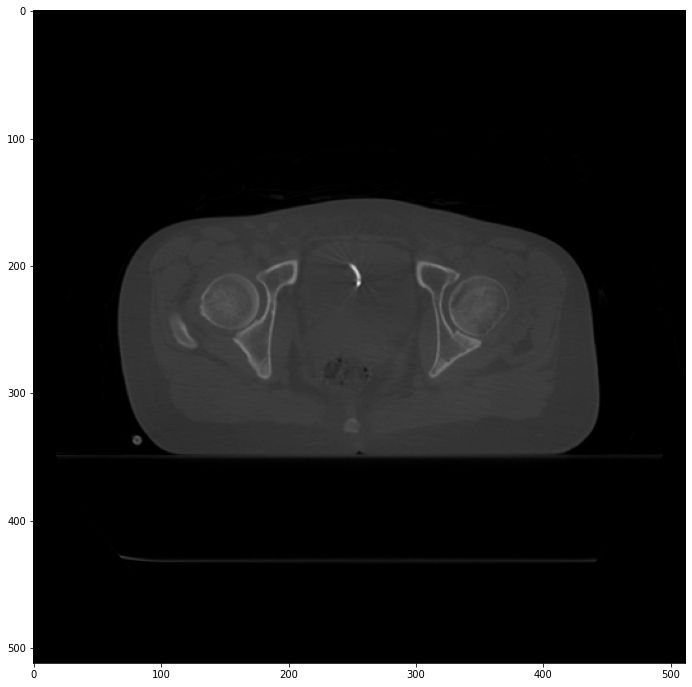

In [85]:
show_raw_pixel(slices[20])


In [86]:
#plot histogram

def show_raw_hist(slices):
    plt.hist(slices.pixel_array.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

RescaleIntercept :-1000
RescaleSlope :1


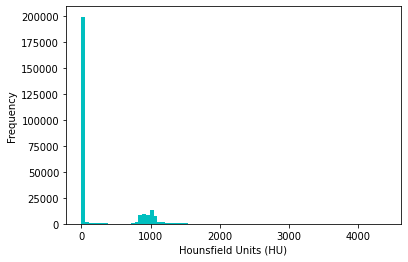

In [38]:
show_raw_hist(read_dicom('data/20201110_CBCT加reg檔案/L224_GYN/20190308_CBCT')[60])


# Get HU values

DICOM裡面每個像素儲存的值並不是直接就是HU，而是必須透過DICOM中的Rescale Intercept 和 Rescale Slope經過轉換公式來取得，公式如下  Outputunits=m×SV+b 
其中m 就是Rescale Slope，b就是Rescale Intercept，SV(stored values)就是每個pixel儲存的值。
有些CT的機器掃描出來的圖式圓形的，但是最後儲存的圖都是方形的，因此圖片中沒有資訊的部分，機器儲存的pixel值會比空氣還小很多(這個圖檔為-1000)。所以在轉換成HU之前，小於0的pixel值設定跟空氣一樣為0，轉換之後的HU就會跟空氣一樣是-1000 以下函式會計算出每個像素的HU

In [73]:
def get_pixels_hu(slices):
    #讀出像素值並且儲存成numpy的格式
    image = np.stack([s.pixel_array for s in slices])

    # 將超過機器掃描範圍的部分設為 0
    # 通常intercept是 -1024, 經過計算之後空氣大約是 0
    image[image < 0] = 0
    
    # 轉換為Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] = image[slice_number].astype(np.int16) + np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

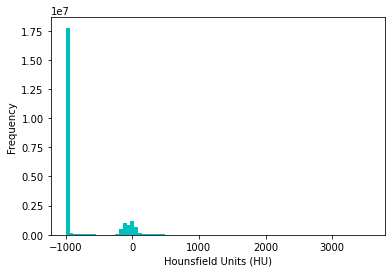

In [76]:
patient_pixels = get_pixels_hu(slices)
plt.hist(patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

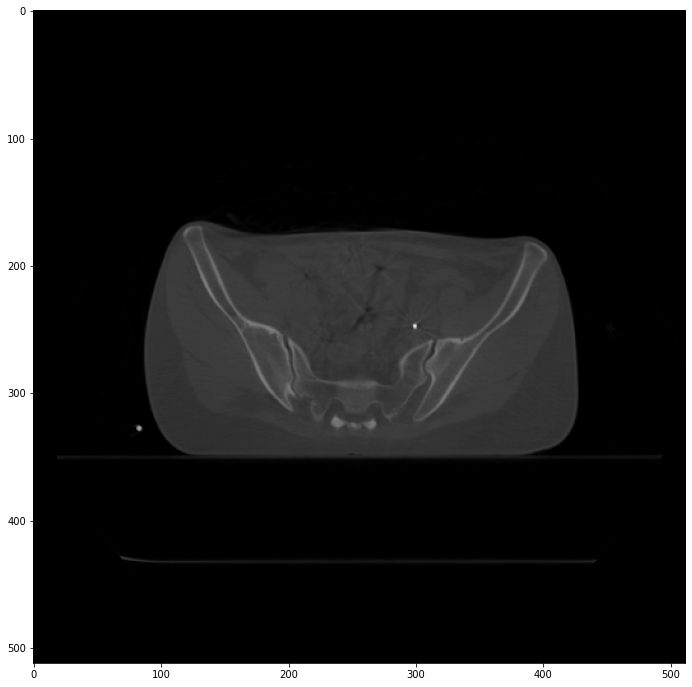

In [81]:
# Show some slice in the middle
plt.figure(figsize = (12,12))
plt.imshow(patient_pixels[60], cmap=plt.cm.gray)
plt.show()

# Resampling

## 面函式對原本的3維照片進行縮放，讓所有圖檔的spacing都變成 1mm×1mm×1mm

In [ ]:
    #取出原本的spacing
    #[scan[0].SliceThickness] + list(scan[0].PixelSpacing) 會組成一個list，裡面是的spacing數值
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float64)


    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    #計算出放大參數後，用scipy對3為照片進行縮放，scipy會自動為圖片進行插補
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

In [23]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized